# Rosenzweig-MacArthur Reaction-Diffusion Model

**Authors:** Ege Seçgin, Elia Salerno  
**Course:** ALCS Mathematical Modelling  


## Setup Instructions

This project requires Python 3.13.

We recommend using [Astral's package manager 'uv'](https://docs.astral.sh/uv/) for installing dependencies.  
The `pyproject.toml` file allows you to set up a high-performance environment with `uv sync`.

For compatibility, we also provide an `environment.yml` file.  
You can set up the environment with `conda env create -f environment.yml` and activate it using `conda activate v5-2-es-es-report`. When using VSCode with the Jupyter extension, you may be prompted to install IPykernel when running the notebook, please accept the installation to run.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

PLOT_DIR = "plots/"
PLOT_DPI = 300
SAVE_PLOT_OUTPUTS = True

if SAVE_PLOT_OUTPUTS:
    os.makedirs(PLOT_DIR, exist_ok=True)

## Model Equations

$$\frac{\partial u}{\partial t} = D_u \nabla^2 u + ru \left( 1 - \frac{u}{K} \right) - \frac{\alpha u v}{1 + h u}$$

$$\frac{\partial v}{\partial t} = D_v \nabla^2 v + \beta \frac{\alpha u v}{1 + h u} - mv$$

where $u$ is prey density, $v$ is predator density, with logistic growth and Holling Type-II functional response.

In [2]:
L = 100.0
N = 128
dx = L / N

Du = 0.5    # m^2/d
Dv = 0.05   # m^2/d
r = 0.5     # d^-1
K = 500.0   # ind/m^2
alpha = 0.01 # m^2 /(ind d)
h = 0.05    # ind^-1
beta = 0.3  # conversion efficiency
m = 0.05    # d^-1

total_time = 500.0

## Spatial Resolution

$$\Delta x = \frac{L}{N}$$

## Initial Conditions

Localized perturbations to trigger pattern formation.

## Time Step

CFL stability condition for 2D diffusion:

$$\Delta t_{\max} = \frac{(\Delta x)^2}{4 \cdot D_{\max}}$$

In [3]:
max_D = max(Du, Dv)
dt_max_diffusion = dx**2 / (4 * max_D)

# Account for reaction term stiffness
reaction_timescale = 1.0 / max(r, m, alpha)
dt_max_reaction = 0.1 * reaction_timescale

dt = min(0.9 * dt_max_diffusion, dt_max_reaction)
time_steps = int(total_time / dt)
print(f"dt = {dt:.4f} (diffusion limit: {dt_max_diffusion:.4f}, reaction limit: {dt_max_reaction:.4f})")

dt = 0.2000 (diffusion limit: 0.3052, reaction limit: 0.2000)


## Laplacian Operator

The Laplacian $\nabla^2 u$ represents diffusion in 2D using the 5-point stencil:

$$\nabla^2 u \approx \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{(\Delta x)^2}$$

## Steady State Analysis

Computing Homogeneous coexistence equilibrium by setting reaction terms to zero.

In [4]:
def find_steady_state(r, K, alpha, h, beta, m):
    denominator = beta * alpha - m * h
    if denominator <= 0:
        return None, None
    u_star = m / denominator
    v_star = (r / alpha) * (1 + h * u_star) * (1 - u_star / K)
    if u_star > 0 and v_star > 0 and u_star < K:
        return u_star, v_star
    return None, None

u_ss, v_ss = find_steady_state(r, K, alpha, h, beta, m)

if u_ss is None:
    raise ValueError("no valid coexistence steady state w/ current parameters")
else:
    print(f"steady state at u* = {u_ss:.4f}, v* = {v_ss:.4f}")
    
    np.random.seed(42)
    U = np.full((N, N), u_ss)
    V = np.full((N, N), v_ss)
    
    cx1, cy1 = N // 3, N // 3
    cx2, cy2 = 2 * N // 3, 2 * N // 3
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    dist1 = np.sqrt((X - cx1)**2 + (Y - cy1)**2)
    dist2 = np.sqrt((X - cx2)**2 + (Y - cy2)**2)
    
    U[dist1 < 10] = u_ss * 1.2
    V[dist1 < 10] = v_ss * 0.8
    U[dist2 < 10] = u_ss * 0.8
    V[dist2 < 10] = v_ss * 1.2
    
    U = np.maximum(U, 0.01)
    V = np.maximum(V, 0.01)

steady state at u* = 100.0000, v* = 240.0000


## Numerical Solver

FTCS scheme with periodic boundary conditions.

In [5]:
@jit(nopython=True)
def solve_pde(U, V, dx, dt, time_steps, Du, Dv, r, K, alpha, h, beta, m):
    rows, cols = U.shape
    d2 = dx * dx
    
    for step in range(time_steps):
        U_new = np.zeros_like(U)
        V_new = np.zeros_like(V)
        
        for i in range(rows):
            for j in range(cols):
                ip = (i + 1) % rows
                im = (i - 1 + rows) % rows
                jp = (j + 1) % cols
                jm = (j - 1 + cols) % cols
                
                lap_u = (U[ip, j] + U[im, j] + U[i, jp] + U[i, jm] - 4 * U[i, j]) / d2
                lap_v = (V[ip, j] + V[im, j] + V[i, jp] + V[i, jm] - 4 * V[i, j]) / d2
                
                u_curr = U[i, j]
                v_curr = V[i, j]
                
                predation = (alpha * u_curr * v_curr) / (1.0 + h * u_curr)
                
                du_dt = Du * lap_u + r * u_curr * (1.0 - u_curr / K) - predation
                dv_dt = Dv * lap_v + beta * predation - m * v_curr
                
                U_new[i, j] = u_curr + dt * du_dt
                V_new[i, j] = v_curr + dt * dv_dt
                
                if U_new[i, j] < 0:
                    U_new[i, j] = 0.0
                if V_new[i, j] < 0:
                    V_new[i, j] = 0.0
        
        U[:] = U_new
        V[:] = V_new
    
    return U, V

In [6]:
U_final, V_final = solve_pde(U.copy(), V.copy(), dx, dt, time_steps, Du, Dv, r, K, alpha, h, beta, m)

## Spatial Distribution

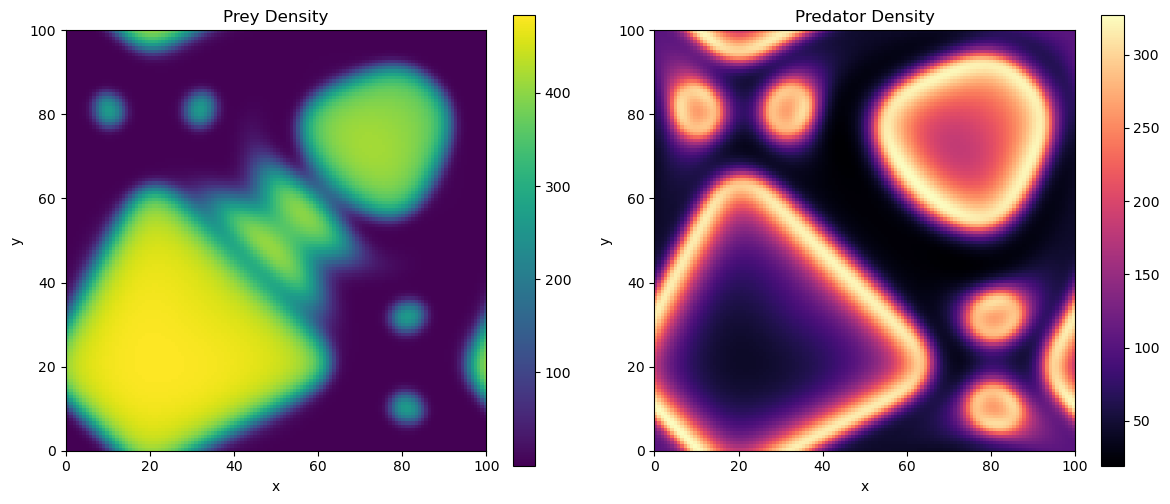

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(U_final, cmap='viridis', origin='lower', extent=[0, L, 0, L])
axes[0].set_title('Prey Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(V_final, cmap='magma', origin='lower', extent=[0, L, 0, L])
axes[1].set_title('Predator Density')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()

if SAVE_PLOT_OUTPUTS:
    fig.savefig(PLOT_DIR + "spatial_distribution.png", dpi=PLOT_DPI)

## Temporal Evolution

prey density range: 237.33 to 496.40
predator density range: 18.68 to 398.03


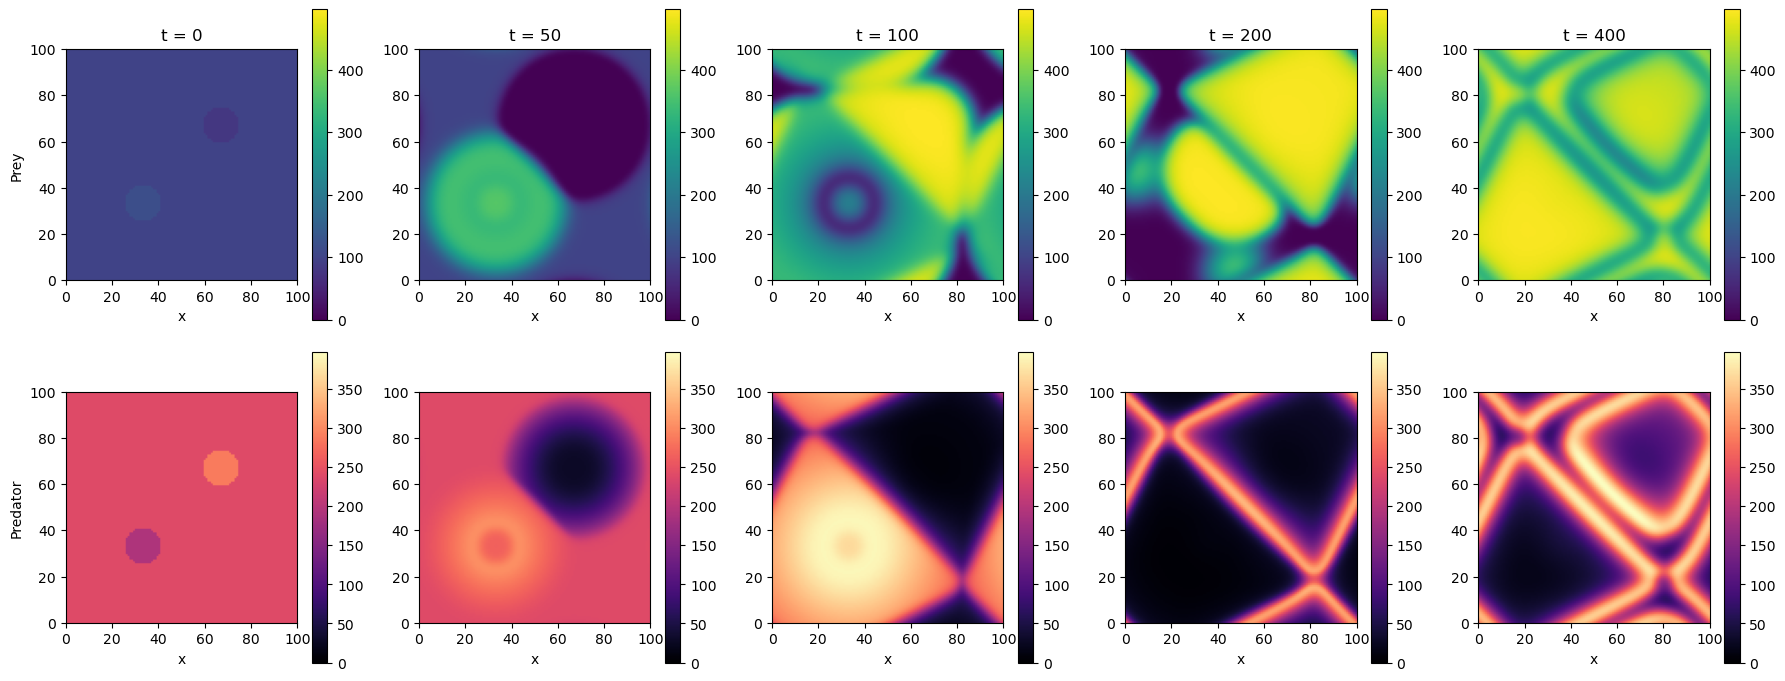

In [8]:
snapshot_times = [0, 50, 100, 200, 400]
snapshots_U, snapshots_V = [], []
U_temp, V_temp = U.copy(), V.copy()

for t_target in snapshot_times:
    steps_to_run = int(t_target / dt)
    if t_target == 0:
        snapshots_U.append(U_temp.copy())
        snapshots_V.append(V_temp.copy())
    else:
        prev_steps = int(snapshot_times[len(snapshots_U)-1] / dt)
        U_temp, V_temp = solve_pde(U_temp, V_temp, dx, dt, steps_to_run - prev_steps, 
                                    Du, Dv, r, K, alpha, h, beta, m)
        snapshots_U.append(U_temp.copy())
        snapshots_V.append(V_temp.copy())

u_max = max(np.max(u) for u in snapshots_U)
v_max = max(np.max(v) for v in snapshots_V)

fig, axes = plt.subplots(2, len(snapshot_times), figsize=(18, 7))

for i, t in enumerate(snapshot_times):
    axes[0, i].imshow(snapshots_U[i], cmap='viridis', origin='lower', 
                      extent=[0, L, 0, L], vmin=0, vmax=u_max)
    axes[0, i].set_title(f't = {t}')
    axes[0, i].set_xlabel('x')
    if i == 0:
        axes[0, i].set_ylabel('Prey')
    
    axes[1, i].imshow(snapshots_V[i], cmap='magma', origin='lower', 
                      extent=[0, L, 0, L], vmin=0, vmax=v_max)
    axes[1, i].set_xlabel('x')
    if i == 0:
        axes[1, i].set_ylabel('Predator')

for i in range(len(snapshot_times)):
    fig.colorbar(axes[0, i].images[0], ax=axes[0, i])
    fig.colorbar(axes[1, i].images[0], ax=axes[1, i])

plt.tight_layout()

if SAVE_PLOT_OUTPUTS:
    fig.savefig(PLOT_DIR + "temporal_evolution.png", dpi=PLOT_DPI)

print(f"prey density range: {np.min(snapshots_U[-1]):.2f} to {u_max:.2f}")
print(f"predator density range: {np.min(snapshots_V[-1]):.2f} to {v_max:.2f}")

## Diffusion Ratio Analysis


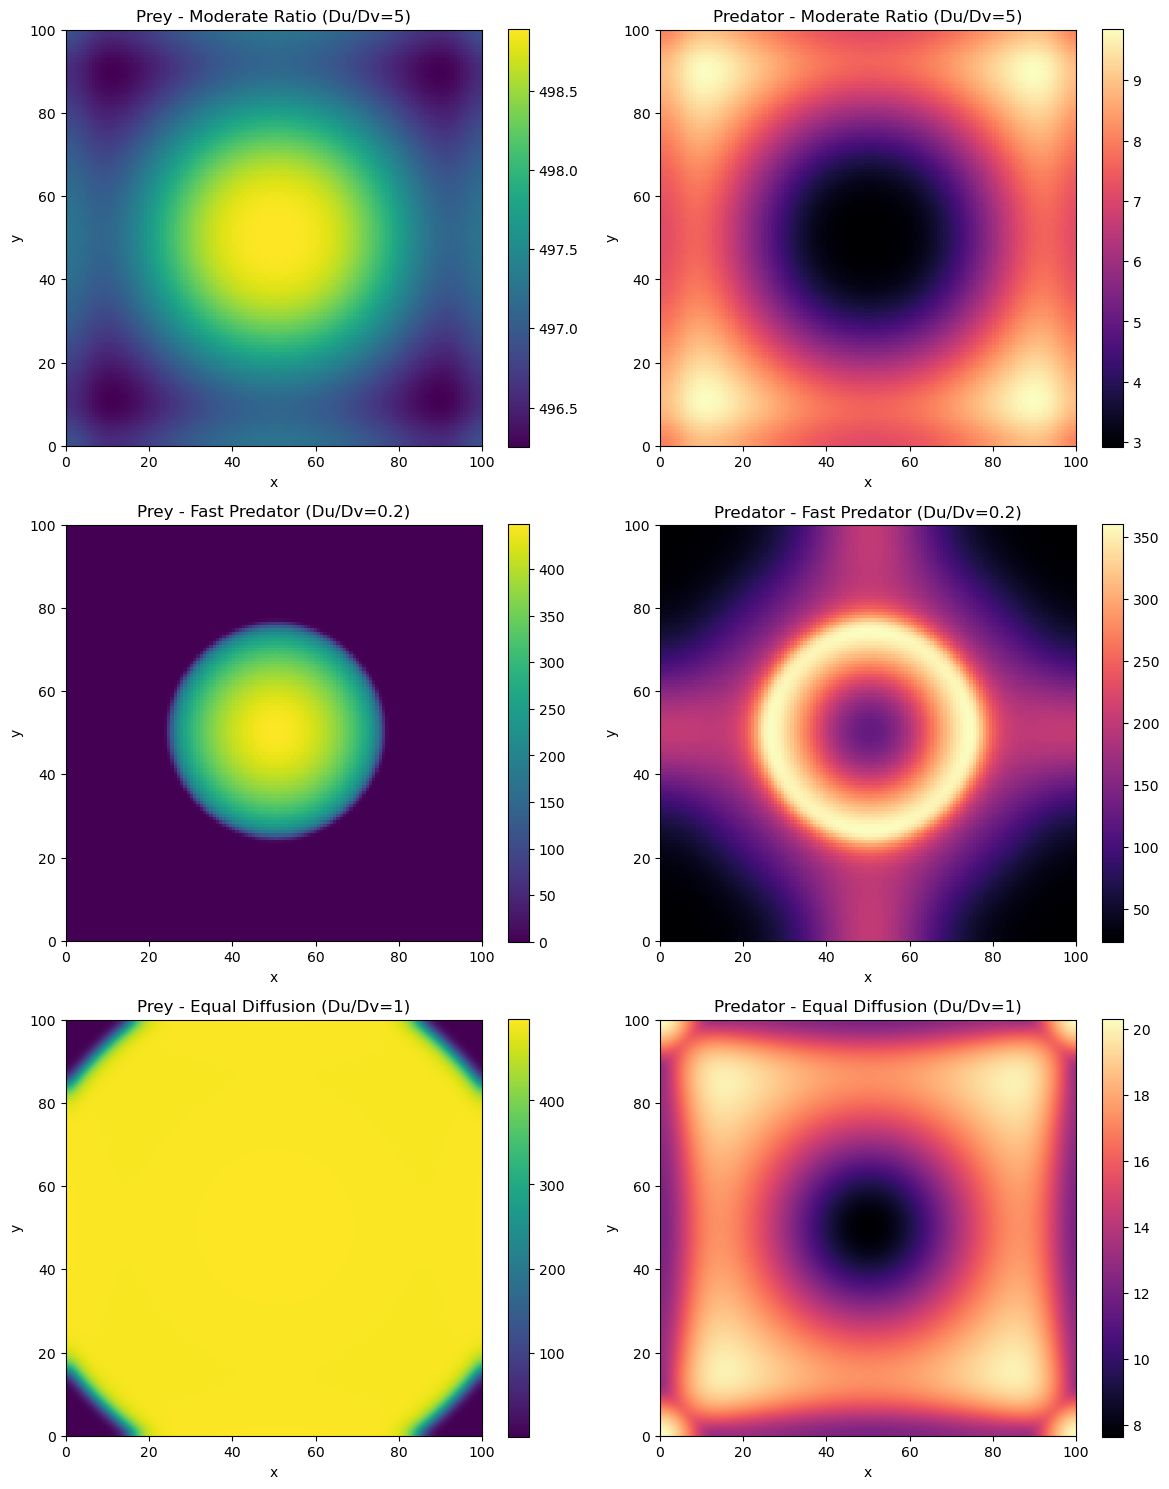

In [9]:
test_params = [
    {"Du": 0.5, "Dv": 0.1, "label": "Moderate Ratio (Du/Dv=5)"}, 
    {"Du": 0.1, "Dv": 0.5, "label": "Fast Predator (Du/Dv=0.2)"}, 
    {"Du": 0.2, "Dv": 0.2, "label": "Equal Diffusion (Du/Dv=1)", "N": 256},
]

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

for idx, params in enumerate(test_params):
    Du_test, Dv_test = params["Du"], params["Dv"]
    N_test = params.get("N", N)  # Use higher resolution if specified
    dx_test = L / N_test
    
    # Stability accounting for both diffusion and reaction
    dt_test_diff = dx_test**2 / (4 * max(Du_test, Dv_test))
    dt_test_reac = 0.1 / max(r, m, alpha)
    dt_test = min(0.9 * dt_test_diff, dt_test_reac)
    steps_test = int(300.0 / dt_test)
    
    U_test = np.full((N_test, N_test), u_ss)
    V_test = np.full((N_test, N_test), v_ss)
    cx, cy = N_test // 2, N_test // 2
    X_test, Y_test = np.meshgrid(np.arange(N_test), np.arange(N_test))
    dist_test = np.sqrt((X_test - cx)**2 + (Y_test - cy)**2)
    U_test[dist_test < 10] = u_ss * 1.2
    V_test[dist_test < 10] = v_ss * 0.8
    U_test = np.maximum(U_test, 0.01)
    V_test = np.maximum(V_test, 0.01)
    
    U_test, V_test = solve_pde(U_test, V_test, dx_test, dt_test, steps_test, 
                                Du_test, Dv_test, r, K, alpha, h, beta, m)
    
    im1 = axes[idx, 0].imshow(U_test, cmap='viridis', origin='lower', extent=[0, L, 0, L])
    axes[idx, 0].set_title(f'Prey - {params["label"]}')
    axes[idx, 0].set_xlabel('x')
    axes[idx, 0].set_ylabel('y')
    fig.colorbar(im1, ax=axes[idx, 0])
    
    im2 = axes[idx, 1].imshow(V_test, cmap='magma', origin='lower', extent=[0, L, 0, L])
    axes[idx, 1].set_title(f'Predator - {params["label"]}')
    axes[idx, 1].set_xlabel('x')
    axes[idx, 1].set_ylabel('y')
    fig.colorbar(im2, ax=axes[idx, 1])

plt.tight_layout()

if SAVE_PLOT_OUTPUTS:
    fig.savefig(PLOT_DIR + "diffusion_ratio_analysis.png", dpi=PLOT_DPI)

## Linear Stability Analysis


In [10]:
def compute_jacobian(u, v, r, K, alpha, h, beta, m):
    denom = 1 + h * u
    a = r * (1 - 2*u/K) - alpha * v / denom**2
    b = -alpha * u / denom
    c = beta * alpha * v / denom**2
    d = beta * alpha * u / denom - m
    return np.array([[a, b], [c, d]])

J = compute_jacobian(u_ss, v_ss, r, K, alpha, h, beta, m)
trace, det = np.trace(J), np.linalg.det(J)
discriminant = trace**2 - 4*det

print(f"steady state: u = {u_ss:.4f}, v = {v_ss:.4f}")
print(f"jacobian: trace = {trace:.4f}, det = {det:.4f}")
print(f"discriminant: {discriminant:.4f}")

steady state: u = 100.0000, v = 240.0000
jacobian: trace = 0.2333, det = 0.0033
discriminant: 0.0411
